In [1]:
def DNNModel(df, compnn):
    import torch as pt
    from torch import nn
    from sklearn.model_selection import train_test_split
    import numpy as np

    [train, test] = train_test_split(df, random_state = 117, shuffle = True, train_size = 0.9)

    y_tn = pt.tensor(train.iloc[:, -2:].values, dtype = pt.double)
    y_tt = pt.tensor(test.iloc[:, -2:].values, dtype = pt.double)
    X_tt = pt.tensor(test.iloc[:, :-2].values, dtype = pt.double)
    X_tn = pt.tensor(train.iloc[:, :-2].values, dtype = pt.double)

    
    #Set into train mode
    compnn.train()
    criteria = nn.MSELoss()
    optimizer = pt.optim.Adam(compnn.parameters(), lr=0.0001)
    epochs = 100

    lossvec = np.zeros([epochs])
    for epoch in range(epochs):  # loop over the dataset multiple times

        losstot = 0
        for i, data in enumerate(X_tn, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = compnn(inputs)
            loss = criteria(outputs, y_tn[i, :])
            loss.backward()
            optimizer.step()
            losstot += loss.detach().numpy()

        lossvec[epoch] = losstot
    
    return lossvec, X_tt, y_tt, compnn

In [2]:
from torch import nn
import torch as pt
class CompNN(nn.Module):
    def __init__(self):
        super(CompNN, self).__init__()
        self.dns1 = nn.Linear(Ncomps, 50).double()
        self.dns2 = nn.Linear(50, 50).double()
        self.out = nn.Linear(50, 2).double()

        nn.init.xavier_uniform_(self.dns1.weight)
        nn.init.zeros_(self.dns1.bias)
        nn.init.xavier_uniform_(self.dns2.weight)
        nn.init.zeros_(self.dns2.bias)
        nn.init.xavier_uniform_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    def forward(self, x):
        c = pt.relu(self.dns1(x))
        c = pt.relu(self.dns2(c))
        c = self.out(c)
        return c

In [3]:
def InitialModel(MxN, DataSet, EOS, plot=False):
    from torch import nn
    import torch as pt
    import matplotlib.pyplot as plt
    import sys
    import numpy as np
    import pandas as pd
    import KeyFunctions as me
    
    global Ncomps
    _, Tc, Pc, _, Ncomps, _, _, k, _ = me.LookUpMix(MxN, DataSet, EOS)
    PcN = np.dot(np.ones(Ncomps)*1/Ncomps, Pc)
    TcN = np.dot(np.ones(Ncomps)*1/Ncomps, Tc)
    
    
    #Generate training data
    path = me.GetRootPath()
    path  = path+"/2-TrainingSets/"+DataSet+"/MX_"+str(MxN)+"_Train.csv"
    df = pd.read_csv(path, index_col=0)
    df = df.drop(['Time.1', 'Time', 'Tc_OPT', 'Pc_OPT', 'Vc_NR', 'mixVc'], axis =1, errors='ignore')
    
    df['Pc_NR'] = df['Pc_NR']/PcN
    df['Tc_NR'] = df['Tc_NR']/TcN
    
    compnn = CompNN().to(pt.device("cpu"))

    loss, X_tt , y_tt, trainednn = DNNModel(df, compnn)
    
    
    trainednn.eval()
    y_pred = trainednn(X_tt).detach().numpy()
    Tc_MX_M = y_pred[:, 0]*TcN
    Pc_MX_M = y_pred[:, 1]*PcN
    Tc_MX_C = y_tt.detach().numpy()[:, 0]*TcN
    Pc_MX_C = y_tt.detach().numpy()[:, 1]*PcN
    
    if plot:
        fig, ax = plt.subplots(figsize = [5, 5])
        ax.scatter(y_pred[:, 0], y_pred[:, 1])
        ax.scatter(y_tt[:, 0].detach().numpy(), y_tt[:, 1].detach().numpy())
        ax.legend(["Predicted", "Calculated"])
        ax.set_title("Prediction Space")
        ax.set_xlabel("Normalized Critical Temperature")
        ax.set_ylabel("Normalized Critical Pressure")
    
    
    AD = pd.DataFrame(abs(Tc_MX_M-Tc_MX_C), columns = ['Tc_AD'])
    AD['Pc_AD'] = abs(Pc_MX_M-Pc_MX_C)
    RMSE = [me.RMSE(Tc_MX_M, Tc_MX_C), me.RMSE(Pc_MX_M, Pc_MX_C)]
    RMAE = [me.RMAE(Tc_MX_M, Tc_MX_C), me.RMAE(Pc_MX_M, Pc_MX_C)]
    
    return df, AD, RMSE, RMAE, trainednn

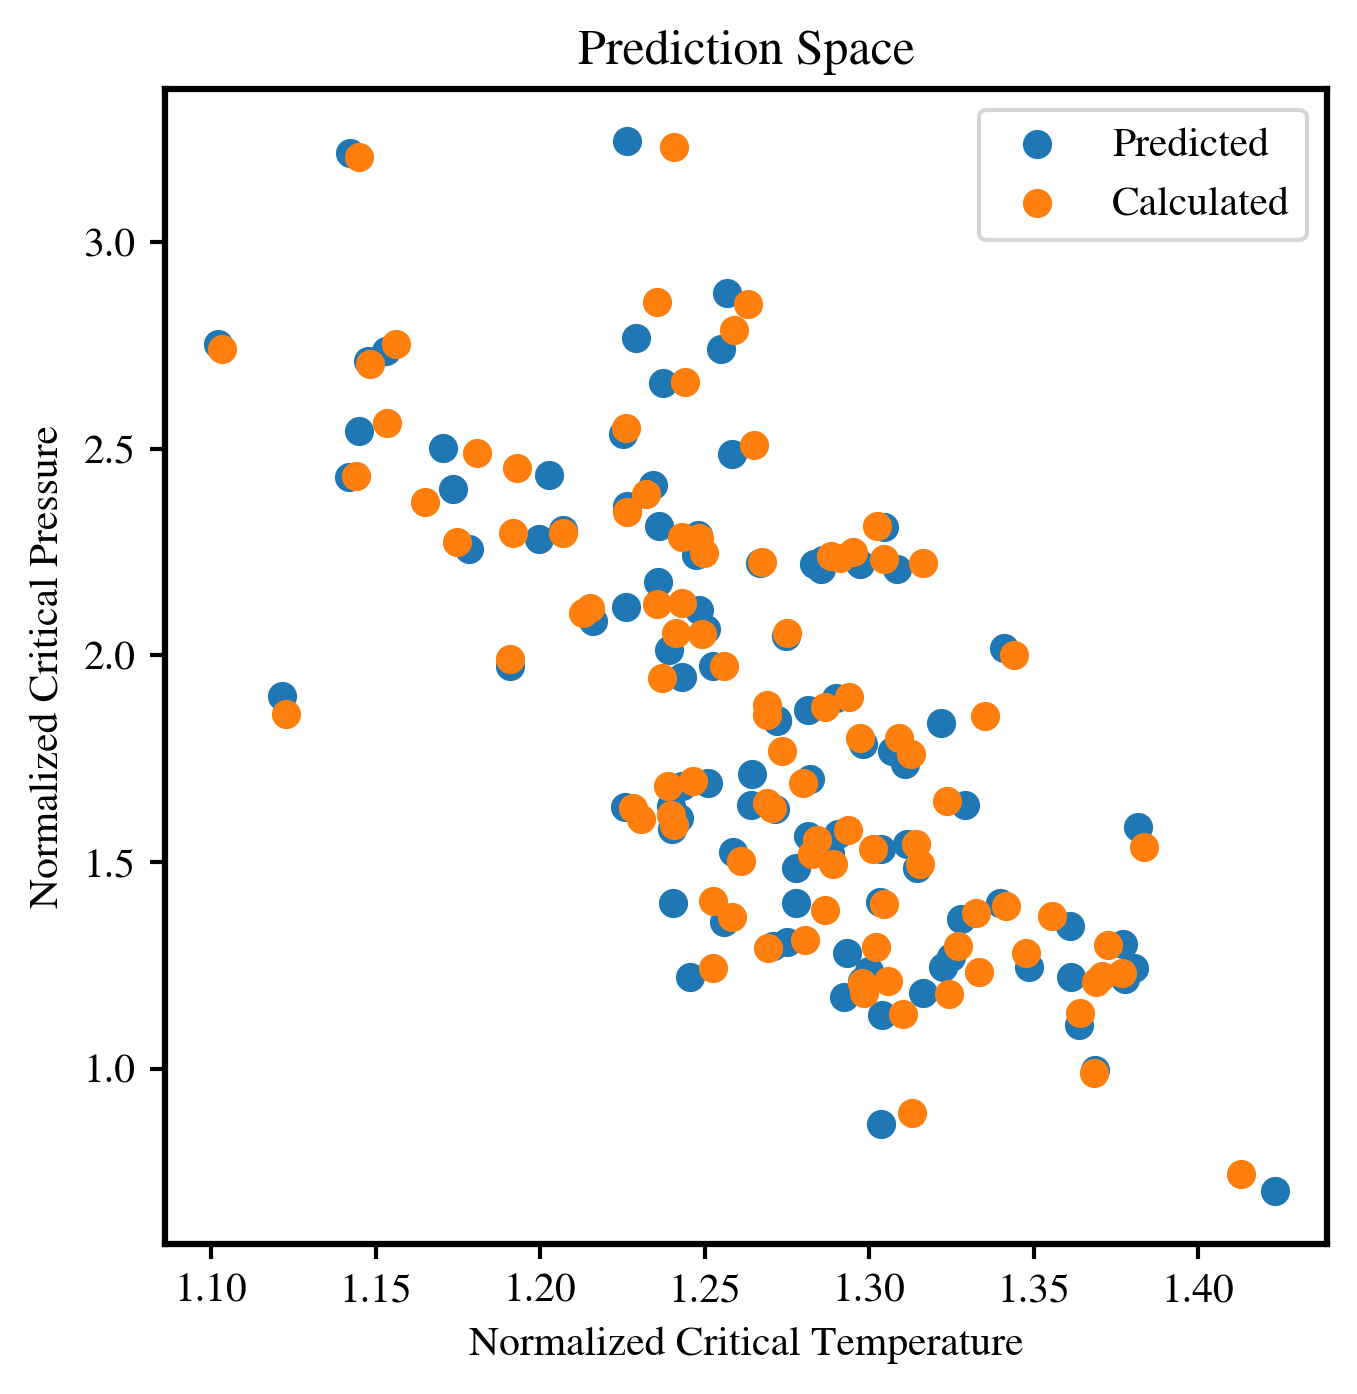

In [4]:
import matplotlib as mlp

mlp.rcParams['font.family'] = 'Nimbus Roman'
mlp.rcParams['figure.dpi']= 300
mlp.rcParams['axes.linewidth'] = 1.5
mlp.rcParams['ytick.major.width'] = 1
mlp.rcParams['xtick.major.width'] = 1

DataSet = 'Ghorayeb-13'
EOS = "PR"
MxN = 1

df, AD, RMSE, RMAE, trainednn = InitialModel(MxN, DataSet, EOS, True)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import numpy as np
import KeyFunctions as me
import torch

_, Tc, Pc, _, Ncomps, _, _, k, _ = me.LookUpMix(MxN, DataSet, EOS)

PcN = np.dot(np.ones(Ncomps)*1/Ncomps, Pc)
TcN = np.dot(np.ones(Ncomps)*1/Ncomps, Tc)

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-2], df.iloc[:, -2:], test_size=0.1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Var = 1
y_pred = trainednn(torch.tensor(X_test)).detach().numpy()
RRMSE = me.RRMSE(y_pred[:, Var], y_test[:, Var])
MARE = me.RMAE(y_pred[:, Var], y_test[:, Var])
MaxAE = np.max(abs(y_pred[:, Var]-y_test[:, Var])/y_test[:, Var])
r2 = r2_score(y_test[:, Var], y_pred[:, Var])
print([RRMSE, MARE, MaxAE, r2])

[0.000932654828505707, 0.0035410719577057227, 0.03207440035493704, 0.9990881677202597]


In [6]:
PcN

2804000.0000000005

In [7]:
RMSE

[1.9692011677944324e-05, 0.00012771658386378503]

In [8]:
df.drop()

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'